<a href="https://colab.research.google.com/github/Elathius/fraud_detection/blob/master/fraud_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Fraud detection exercise

Links:
https://www.kaggle.com/mlg-ulb/creditcardfraud/kernels?sortBy=hotness&group=everyone&pageSize=20&datasetId=310&language=Python
https://www.kaggle.com/shelars1985/anomaly-detection-using-gaussian-distribution



In [2]:
from google.colab import drive
drive.mount('/content/drive')
%cd "/content/drive/My Drive/Colab Notebooks"

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/My Drive/Colab Notebooks


Imports

In [0]:
import numpy as np
import pandas as pd
import sklearn as sk
import matplotlib.pyplot as plt
from sklearn.preprocessing import scale
from sklearn import linear_model
from sklearn.ensemble import IsolationForest
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report,accuracy_score
from sklearn.model_selection import train_test_split
import random
import seaborn as sns
import matplotlib.gridspec as gridspec
import plotly.graph_objs as go
from plotly.offline import download_plotlyjs,init_notebook_mode,plot,iplot

Read & Store dataset

In [4]:
df = pd.read_csv('creditcard.csv', low_memory = False)
df = df.sample(frac=1).reset_index(drop=True)
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,35838.0,1.158171,0.062161,0.265693,1.208426,-0.056950,0.294108,-0.154507,0.241099,0.284155,0.092615,0.609717,0.303202,-1.675737,0.542711,-0.604972,-0.360768,-0.020156,-0.191145,0.058226,-0.280713,-0.093625,-0.124691,-0.090292,-0.329324,0.628367,-0.304030,0.027114,-0.002012,1.00,0
1,146222.0,1.919806,-0.285027,-2.496197,-0.277402,1.502951,0.862554,0.341983,0.137368,-0.160038,0.231143,0.998750,0.606678,-0.450806,1.043294,0.488774,-0.763042,0.035298,-1.237897,-0.518170,-0.180547,0.179530,0.526810,0.026164,-0.886122,0.046595,0.806837,-0.096158,-0.095476,53.05,0
2,65385.0,-6.424397,-8.148589,-0.955982,-0.589680,2.404739,2.596165,-0.840264,1.666921,-0.778153,-0.966318,-0.976359,-0.377604,0.363399,-0.230615,-0.804455,1.527044,0.179437,-0.468411,0.460390,3.775540,1.011499,-0.684899,1.780361,0.961957,0.946410,-0.378638,-0.020485,-0.735515,901.50,0
3,148670.0,-1.276606,0.781967,0.592544,-0.483963,2.414370,0.855608,1.273145,0.161515,-0.594324,-0.274043,0.711582,0.090693,-1.478522,0.559165,-0.835605,-1.181230,0.027753,-1.219593,-1.386546,-0.221866,0.036634,0.485890,-0.720734,-1.517049,1.124649,-0.363827,0.029607,-0.175221,3.18,0
4,92373.0,-2.131712,2.257061,-0.058957,-0.823472,-0.755555,-0.634886,-0.559761,1.000383,2.245374,-0.510678,1.876006,-1.926013,0.778087,0.624568,-0.892618,0.880018,1.263660,1.131623,-0.499512,0.217136,-0.371160,-0.833209,0.132096,-0.222403,-0.047889,-0.313153,0.146666,0.204106,3.76,0


Count metrics

In [5]:
fraud = df.loc[df['Class']==1]
non_fraud = df.loc[df['Class']==0]
tot =  len(fraud)+len(non_fraud)
print("Fraudulent: ",len(fraud)," ", (len(fraud)/tot)*100,"%")
print("Normal    : ",len(non_fraud)," ", (len(non_fraud)/tot)*100,"%")

Fraudulent:  492   0.1727485630620034 %
Normal    :  284315   99.82725143693798 %


Comparision visualizations:

Text(0, 0.5, 'Frequency')

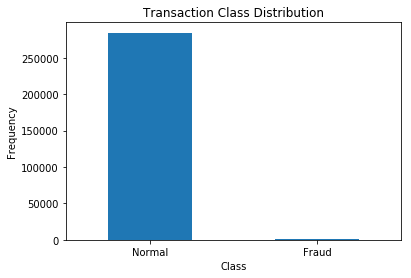

In [6]:
LABELS = ["Normal", "Fraud"]
count_classes = pd.value_counts(df['Class'], sort = True)
count_classes.plot(kind = 'bar', rot=0)
plt.title("Transaction Class Distribution")
plt.xticks(range(2), LABELS)
plt.xlabel("Class")
plt.ylabel("Frequency")

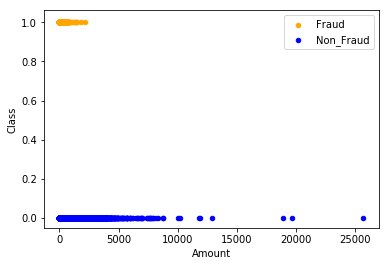

In [7]:
ax = fraud.plot.scatter(x='Amount', y='Class',color='Orange', label='Fraud')
non_fraud.plot.scatter(x='Amount', y='Class',color='Blue', label='Non_Fraud', ax = ax)
plt.show()

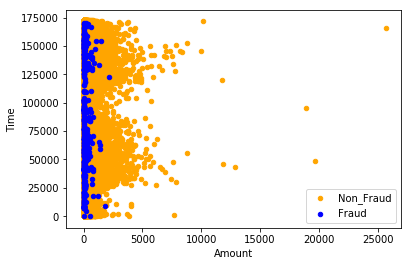

In [8]:
ax = non_fraud.plot.scatter(x='Amount', y='Time',color='Orange', label='Non_Fraud')
fraud.plot.scatter(x='Amount', y='Time',color='Blue', label='Fraud', ax = ax)
plt.show()

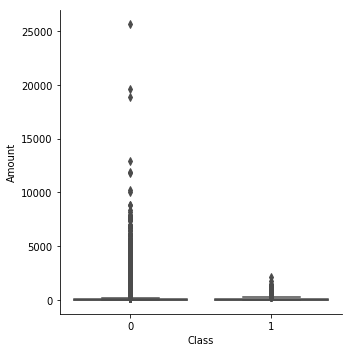

In [9]:
sns.catplot(y="Amount", x="Class",kind="box", data=df,color='blue')

In [10]:

x = df.iloc[:, :-1]
y = df['Class']


data1= df.sample(frac = 0.1,random_state=1)

data1.shape


(28481, 31)

Visualizing for which features can contribute to learning more

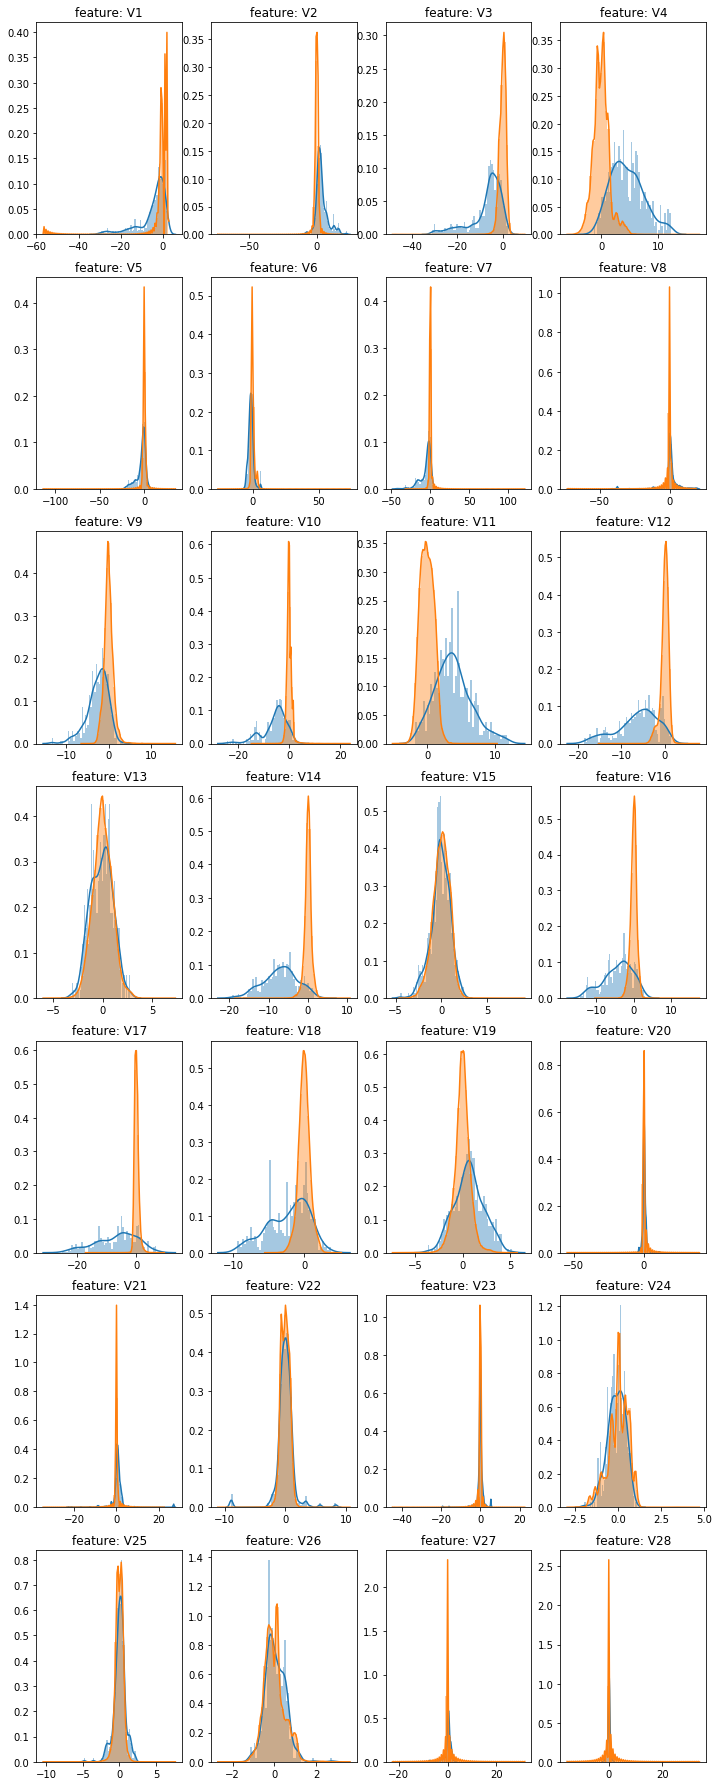

In [11]:

train_df = df
v_features = train_df.iloc[:,1:29].columns
plt.figure(figsize=(12,8*4))
gs = gridspec.GridSpec(7, 4)
for i, cn in enumerate(train_df[v_features]):
    ax = plt.subplot(gs[i])
    sns.distplot(train_df[cn][train_df.Class == 1], bins=50)
    sns.distplot(train_df[cn][train_df.Class == 0], bins=50)
    ax.set_xlabel('')
    ax.set_title('feature: ' + str(cn))
plt.show()

In [12]:
rnd_clf = RandomForestClassifier(n_estimators = 100 , criterion = 'entropy',random_state = 0)
rnd_clf.fit(train_df.iloc[:,1:29],train_df.iloc[:,30])


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=0, verbose=0,
                       warm_start=False)

In [13]:
x, y = (list(x) for x in zip(*sorted(zip(rnd_clf.feature_importances_, train_df.iloc[:,1:29].columns), 
                                                            reverse = False)))
trace2 = go.Bar(
    x=x ,
    y=y,
    marker=dict(
        color=x,
        colorscale = 'Viridis',
        reversescale = True
    ),
    name='Random Forest Feature importance',
    orientation='h',
)

layout = dict(
    title='Barplot of Feature importances',
     width = 600, height = 1000,
    yaxis=dict(
        showgrid=False,
        showline=False,
        showticklabels=True,
#         domain=[0, 0.85],
    ),
    margin=dict(
    l=300,
),
)

fig1 = go.Figure(data=[trace2], layout=layout)
iplot(fig1)

Features that are important i.e. above threshold (other features may be ignored)


In [14]:
for name, importance in zip(train_df.iloc[:,1:29].columns, rnd_clf.feature_importances_):
    if importance > 0.020 :
        print('"' + name + '"'+',')

"V3",
"V4",
"V7",
"V9",
"V10",
"V11",
"V12",
"V14",
"V16",
"V17",


Drop un-important features to optimize training

In [0]:
#Drop the un-important features 

df.drop(['V19','V21','V1','V2','V6','V5','V28','V27','V26','V25','V24','V23','V22','V20','V15','V13','V8'], axis =1, inplace = True)


xt = df.iloc[:, :-1]
yt = df['Class']

X_train, X_test, y_train, y_test = train_test_split(xt,yt, test_size=0.35)

Logistic regression:

In [16]:
logistic = linear_model.LogisticRegression(C=1e5)
logistic.fit(X_train,y_train)

print(logistic.score(X_test,y_test))

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning:

Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.



0.9991071697280379


Random Forest:

In [17]:
modelforest = RandomForestClassifier()
modelforest.fit(X_train,y_train)
print(modelforest.score(X_test,y_test))

/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/forest.py:245: FutureWarning:

The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.



0.9994883781587632
